In [1]:
import tensorflow as tf
import numpy as np
import mnist_handler
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="3"; 
INPUT_DIMENSION = 28*28
NUM_CLASSES = 10

"""load MNIST"""
x_train, x_test, y_train, y_test = mnist_handler.load_mnist('mnist.npz')
x_train = x_train/255.0
x_test = x_test/255.0
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

border = 5000
x_train_init = x_train[:border]
y_train_init = y_train[:border]
x_train_seq = x_train[border:]
y_train_seq = y_train[border:]

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [2]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X = tf.placeholder(tf.float32, [None, 28, 28])
X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(-5))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [3]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [4]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

# Initial Training

In [5]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init



In [6]:
beta_1_init

<tf.Tensor 'Assign_3:0' shape=(10, 10) dtype=float32_ref>

In [7]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [8]:

'''With one subnetwork'''
logits_init = subnet_output(alpha_1, beta_1, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [9]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [10]:
"""Initial training"""
sess.run(E_1_init, feed_dict={X: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.046516575
Initial train training accuracy:  0.83753335
Initial train testing loss:  0.046722002
Initial train testing accuracy:  0.8373


In [11]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [12]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
"""Initial training"""
sess.run(E_2_init, feed_dict={X: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.047747135
Initial train training accuracy:  0.84178334
Initial train testing loss:  0.047822822
Initial train testing accuracy:  0.8405


In [14]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [15]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [16]:
"""Initial training"""
sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.04733694
Initial train training accuracy:  0.84101665
Initial train testing loss:  0.047438834
Initial train testing accuracy:  0.841


In [17]:
logits_init = subnet_output(alpha_1, beta_1, X_)+ subnet_output(alpha_2, beta_2, X_)

[7]
7


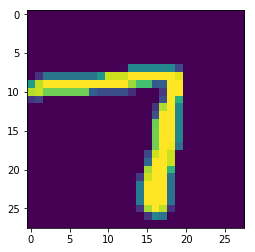

In [18]:
logic = sess.run(logits_init, feed_dict={X : [x_test[4200]]})
print(np.argmax(logic,axis =1))
print(y_test[4200])
plt.imshow(x_test[4200])

[4]
9


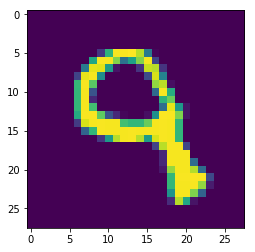

In [19]:
logic = sess.run(logits_init, feed_dict={X : [x_test[4000]]})
print(np.argmax(logic,axis =1))
print(y_test[4000])
plt.imshow(x_test[4000])

# Sequential Training

In [20]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq




In [21]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [22]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [23]:
"""Sequential training"""
batch_size = 2000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(10):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)

train_loss: 0.049003, train_accuracy: 0.833417
test_loss: 0.049022, test_accuracy: 0.838400
train_loss: 0.047744, train_accuracy: 0.837183
test_loss: 0.047853, test_accuracy: 0.844300
train_loss: 0.047359, train_accuracy: 0.838667
test_loss: 0.047505, test_accuracy: 0.846400
train_loss: 0.047180, train_accuracy: 0.839467
test_loss: 0.047346, test_accuracy: 0.847300
train_loss: 0.047078, train_accuracy: 0.840100
test_loss: 0.047257, test_accuracy: 0.848200
train_loss: 0.047012, train_accuracy: 0.840400
test_loss: 0.047201, test_accuracy: 0.848300
train_loss: 0.046966, train_accuracy: 0.840650
test_loss: 0.047161, test_accuracy: 0.848400
train_loss: 0.046931, train_accuracy: 0.840833
test_loss: 0.047132, test_accuracy: 0.848500
train_loss: 0.046905, train_accuracy: 0.840850
test_loss: 0.047110, test_accuracy: 0.848800
train_loss: 0.046884, train_accuracy: 0.840883
test_loss: 0.047092, test_accuracy: 0.848600
Sequential training done


'Sequential training evaluation'

In [24]:
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [25]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [26]:
"""Sequential training"""
batch_size = 2000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(10):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_2_seq, feed_dict={X: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

train_loss: 0.049015, train_accuracy: 0.833033
test_loss: 0.049105, test_accuracy: 0.841800
train_loss: 0.047814, train_accuracy: 0.837433
test_loss: 0.047934, test_accuracy: 0.844800
train_loss: 0.047449, train_accuracy: 0.838883
test_loss: 0.047591, test_accuracy: 0.845500
train_loss: 0.047273, train_accuracy: 0.839967
test_loss: 0.047431, test_accuracy: 0.846000
train_loss: 0.047171, train_accuracy: 0.840300
test_loss: 0.047339, test_accuracy: 0.846500
train_loss: 0.047104, train_accuracy: 0.840467
test_loss: 0.047280, test_accuracy: 0.846500
train_loss: 0.047058, train_accuracy: 0.840767
test_loss: 0.047240, test_accuracy: 0.847000
train_loss: 0.047023, train_accuracy: 0.840783
test_loss: 0.047210, test_accuracy: 0.847500
train_loss: 0.046997, train_accuracy: 0.841017
test_loss: 0.047188, test_accuracy: 0.847900
train_loss: 0.046976, train_accuracy: 0.841183
test_loss: 0.047171, test_accuracy: 0.848200
Sequential training done


'Sequential training evaluation'

In [27]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [28]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [29]:
"""Sequential training"""
batch_size = 2000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(10):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_1_seq, feed_dict={X: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X: x_train, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X: x_test, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

train_loss: 0.048605, train_accuracy: 0.829617
test_loss: 0.048742, test_accuracy: 0.835500
train_loss: 0.047181, train_accuracy: 0.833350
test_loss: 0.047379, test_accuracy: 0.839400
train_loss: 0.046788, train_accuracy: 0.834400
test_loss: 0.047017, test_accuracy: 0.840900
train_loss: 0.046613, train_accuracy: 0.835167
test_loss: 0.046862, test_accuracy: 0.841900
train_loss: 0.046516, train_accuracy: 0.835300
test_loss: 0.046778, test_accuracy: 0.841700
train_loss: 0.046455, train_accuracy: 0.835717
test_loss: 0.046725, test_accuracy: 0.842400
train_loss: 0.046412, train_accuracy: 0.835983
test_loss: 0.046689, test_accuracy: 0.842500
train_loss: 0.046381, train_accuracy: 0.835917
test_loss: 0.046663, test_accuracy: 0.842700
train_loss: 0.046357, train_accuracy: 0.836050
test_loss: 0.046642, test_accuracy: 0.842800
train_loss: 0.046338, train_accuracy: 0.835967
test_loss: 0.046626, test_accuracy: 0.843000
Sequential training done


'Sequential training evaluation'

[[-0.17018934 -0.27788433  0.4618344   0.28298777  0.3982411   0.08289856
   0.00597308 -0.07947537 -0.15749553  0.2324988 ]]
2
9


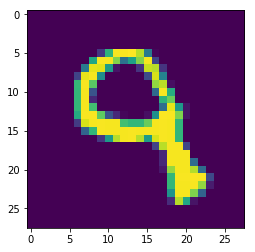

In [30]:
logits_ = subnet_output(alpha_1, beta_1, X_) 
logits__ = sess.run(logits_, feed_dict={X: [x_test[4000]]})
print(logits__)
print(np.argmax(logits__))
print(y_test[4000])
plt.imshow(x_test[4000])

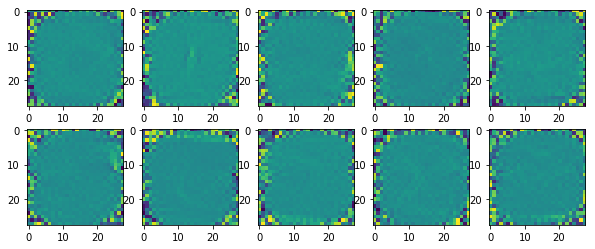

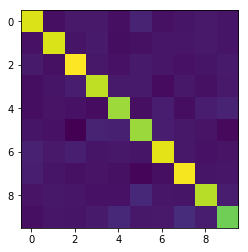

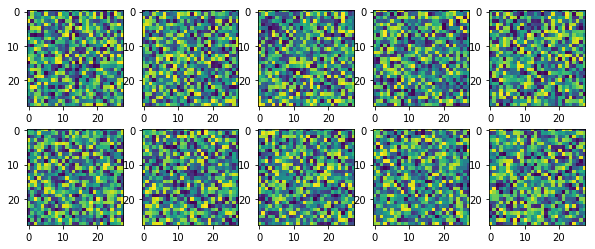

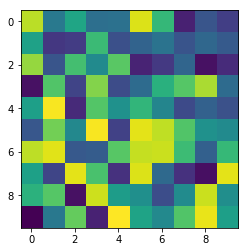

In [31]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
            
"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 28)
visualize_beta(beta_1)
visualize_alpha(alpha_2, 28)
visualize_beta(beta_2)

In [32]:
sess.run(tf.math.sin(tf.constant([0.9])))

array([0.7833269], dtype=float32)